# Tourist satisfaction with transport systems to Mount Etna, Sicily. Part 1. NLP.

# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Academy/+ Papers/en_proceso/mount_etna/'


In [1]:
base_dir = '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/' # To run locally

# 1. Data pre-processing

In [2]:
#!pip install pycaret[full]

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import spacy
#spacy.load("en_core_web_sm")


# NLTK
import string
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Libraries read!')

Libraries read!


[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/juan/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/juan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reading data

In [4]:
data = pd.read_csv(base_dir + 'data/mount_etna_data.csv')
data = data[['author', 'title', 'content', 'rating']]

# Dropping rows without data in content
data = data.dropna(subset = ['content']).reset_index(drop=True)

print('Data shape: ', data.shape)
data.head()

Data shape:  (3419, 4)


author                                              title  \
0  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                             Etna🇮🇹   
1               Teithiwr                         A hard climb, but worth it   
2      elizabethlascheid  You must see an active volcano at least once i...   
3                 Anne N                    Cost of cable car to the top???   
4  Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹                                     Wonderful Etna   

                                             content  rating  
0  East side of the sicilian island, in the Catan...       5  
1  August 2008. Arrived at Refugio Sapienza just ...       4  
2  Mount Etna is extraordinary. It is an active v...       5  
3  How much does the cable car cost from Rifugio ...       4  
4  It's always a great and sensational emotion to...       5

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 to 3418
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   3417 non-null   object
 1   title    3419 non-null   object
 2   content  3419 non-null   object
 3   rating   3419 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 107.0+ KB


# Filtering comments using EACH keyword, to assess imbalance in dataset

In [6]:
TRANSPORT_KEYWORD = ['cable']


for i in TRANSPORT_KEYWORD:
    # Filtering
    data_filtered = data.copy()
    data_filtered['is_transport_related'] = data_filtered['content'].str.contains(i, case=False, na=False)
    data_filtered = data_filtered[data_filtered['is_transport_related']==True].reset_index(drop=True)
    data_filtered = data_filtered.drop(columns=['is_transport_related'])

    # Creating sentiment_rating feature based on rating
    data_filtered['sentiment_rating'] = np.where(data_filtered['rating'] > 3,1,0)
    #TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

    # changing bad and good just for visualization in the recall metric
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace([0,1],['negative', 'positive'])
    data_filtered['sentiment_rating'] = data_filtered['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!



    # Printing datasets    
    print('Dataset using keyword: {}.'.format(i))
    print('Data shape: ', data_filtered.shape)
    print(data_filtered['sentiment_rating'].value_counts(normalize=True))
    display(data_filtered.head(10))
    print('--------------')

Dataset using keyword: cable.
Data shape:  (1352, 5)
0    0.888314
1    0.111686
Name: sentiment_rating, dtype: float64


author                                              title  \
0       Teithiwr                         A hard climb, but worth it   
1         Anne N                    Cost of cable car to the top???   
2  doorstomanual                       Well orgainised, easy access   
3       Emilie P                   Cheap and easy way to do Mt Etna   
4     Jonathan L        Question about Etna Cable Cars and children   
5         John O  Mount Etna - AST bus from Catania, cable car a...   
6       koenevie                        walk mount etna on your own   
7         Gunnel                                           Stunning   
8         Agil N            Spectacular drive up Mount Etna, Sicily   
9    tugcrumpton  One earring to rule them all but take a coat a...   

                                             content  rating  sentiment_rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4                 0  
1  How much does the cable car cost from Rifugio ...       4                 0  
2  We visited Etna with two small children in Aug...       5                 0  
3  We were able to experience Mt Etna without spe...       5                 0  
4  We would like to visit Etna. We have a 3 year ...       5                 0  
5  Mount Etna is a stunning day out from Catania....       4                 0  
6  If you are in good condition, you can climb th...       5                 0  
7  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5                 0  
8  We wanted to see Mount Etna whilst holidaying ...       4                 0  
9  My beloved and I were chatting about various t...       4                 0

--------------


## Filtering comments according to keywords

In [7]:
# TRANSPORT_KEYWORDS = 'transport|rail|cable|car|bus|transportation|mobility|bike'
TRANSPORT_KEYWORDS = 'cable'

In [8]:
# Filtering
data['is_transport_related'] = data['content'].str.contains(TRANSPORT_KEYWORDS, case=False, na=False)
data = data[data['is_transport_related']==True].reset_index(drop=True)
data = data.drop(columns=['is_transport_related'])

# New dataset
print('Data shape: ', data.shape)
data.head(10)

Data shape:  (1352, 4)


author                                              title  \
0       Teithiwr                         A hard climb, but worth it   
1         Anne N                    Cost of cable car to the top???   
2  doorstomanual                       Well orgainised, easy access   
3       Emilie P                   Cheap and easy way to do Mt Etna   
4     Jonathan L        Question about Etna Cable Cars and children   
5         John O  Mount Etna - AST bus from Catania, cable car a...   
6       koenevie                        walk mount etna on your own   
7         Gunnel                                           Stunning   
8         Agil N            Spectacular drive up Mount Etna, Sicily   
9    tugcrumpton  One earring to rule them all but take a coat a...   

                                             content  rating  
0  August 2008. Arrived at Refugio Sapienza just ...       4  
1  How much does the cable car cost from Rifugio ...       4  
2  We visited Etna with two small children in Aug...       5  
3  We were able to experience Mt Etna without spe...       5  
4  We would like to visit Etna. We have a 3 year ...       5  
5  Mount Etna is a stunning day out from Catania....       4  
6  If you are in good condition, you can climb th...       5  
7  We stayed at Nicolosi 25 k's from Mt Etna. It ...       5  
8  We wanted to see Mount Etna whilst holidaying ...       4  
9  My beloved and I were chatting about various t...       4

In [9]:
# Creating sentiment_rating feature based on rating
data['sentiment_rating'] = np.where(data['rating'] > 3,1,0)
#TODO dejar solo 1 y 2 para negativo para tratar de mejorar metricas

# changing bad and good just for visualization in the recall metric
data['sentiment_rating'] = data['sentiment_rating'].replace([0,1],['negative', 'positive'])
data['sentiment_rating'] = data['sentiment_rating'].replace(['negative','positive'],[1, 0]) # NEGATIVE IS 1!!!!

In [10]:
data['sentiment_rating'].value_counts(normalize=True)

0    0.888314
1    0.111686
Name: sentiment_rating, dtype: float64

#### This data is imbalanced, as 90% of the reviews are positive (4, 5) and just 10% are negative (1, 2, 3)

33315


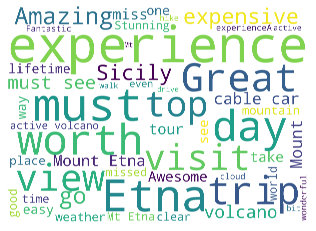

In [11]:
# Wordcloud of title

word_cloud_text = ''.join(data['title'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/cable/title_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

1023350


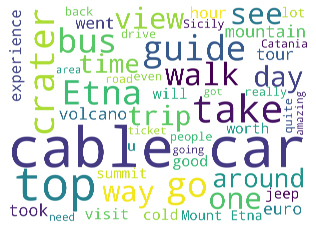

In [12]:
# Wordcloud of content

word_cloud_text = ''.join(data['content'])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=500, 
                      max_words=50,
                      background_color="white",
                      scale=10,
                      width=1000, 
                      height=720).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(0,0.3)
plt.savefig(base_dir + 'output/cable/content_wordcloud.png', dpi=400,  bbox_inches='tight')
plt.show();

# 3. NLP for title

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            1352 non-null   object
 1   title             1352 non-null   object
 2   content           1352 non-null   object
 3   rating            1352 non-null   int64 
 4   sentiment_rating  1352 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 52.9+ KB


In [14]:
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')

In [15]:
noise_words_title = []
token_lists_title = [word_tokenize(each) for each in data['title']]
tokens_title = [item for sublist in token_lists_title for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_title)))


Number of unique tokens then:  1365


In [16]:
one_percentile_title = int(len(set(tokens_title)) * 0.01)
top_1_percentile_title = Counter(tokens_title).most_common(one_percentile_title)
bottom_1_percentile_title = Counter(tokens_title).most_common()[-one_percentile_title:]

print(top_1_percentile_title[:10])
print('---------------')
print(bottom_1_percentile_title[:10])

[('!', 284), ('the', 212), ('to', 170), ('Etna', 151), ('a', 146), ('experience', 136), (',', 114), ('and', 110), ('but', 101), ('A', 97)]
---------------
[('skip', 1), ('overcast', 1), ('HAVE', 1), ('mind-blowing', 1), ('Recommended', 1), ('major', 1), ('piece', 1), ('wish', 1), ('dirty', 1), ('Anticlimax', 1)]


In [17]:
noise_words_title.extend(eng_stop_words)
noise_words_title.extend([word for word, val in top_1_percentile_title])
noise_words_title.extend([word for word, val in bottom_1_percentile_title])

In [18]:
data

author                                        title  \
0          Teithiwr                   A hard climb, but worth it   
1            Anne N              Cost of cable car to the top???   
2     doorstomanual                 Well orgainised, easy access   
3          Emilie P             Cheap and easy way to do Mt Etna   
4        Jonathan L  Question about Etna Cable Cars and children   
...             ...                                          ...   
1347     Thibault J    Fantastic, if you like that kind of thing   
1348        Keith P                             A dusty old hill   
1349       DidgeAFC                                 Trip to Etna   
1350    Peter_Wello            Fire and ice at the top of Sicily   
1351          qio_s                           Exciting adventure   

                                                content  rating  \
0     August 2008. Arrived at Refugio Sapienza just ...       4   
1     How much does the cable car cost from Rifugio ...       4   
2     We visited Etna with two small children in Aug...       5   
3     We were able to experience Mt Etna without spe...       5   
4     We would like to visit Etna. We have a 3 year ...       5   
...                                                 ...     ...   
1347  The landscape is amazing and I would recommend...       5   
1348  Very expensive cable car ride - plus bus to su...       3   
1349  We drove to the base station where you take th...       4   
1350  Fantastic just to drive up the mountain throug...       5   
1351  I've been to Catania for 5 months with Erasmus...       5   

      sentiment_rating  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1347                 0  
1348                 1  
1349                 0  
1350                 0  
1351                 0  

[1352 rows x 5 columns]

In [19]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['title', 'sentiment_rating']],  
                 target = 'title',
                 session_id = 42,
                 custom_stopwords = noise_words_title
                )

In [20]:
lda_title = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title)
lda_title_data = assign_model(lda_title)

In [21]:
print('Shape of lda_title_data: ', lda_title_data.shape)
display(lda_title_data.head())
print('------')
lda_title_data.describe(include='all')

Shape of lda_title_data:  (1352, 8)


title  sentiment_rating   Topic_0   Topic_1   Topic_2  \
0                      hard                 0  0.125029  0.125031  0.125028   
1        cost cable car top                 0  0.441122  0.453204  0.052865   
2     orgainise easy access                 0  0.062592  0.062591  0.062579   
3            cheap easy way                 0  0.063219  0.062522  0.562189   
4  question cable car child                 0  0.050055  0.849834  0.050056   

    Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.624911        Topic 3                 0.62  
1  0.052809        Topic 1                 0.45  
2  0.812239        Topic 3                 0.81  
3  0.312070        Topic 2                 0.56  
4  0.050055        Topic 1                 0.85

------


title  sentiment_rating      Topic_0      Topic_1      Topic_2  \
count   1352       1352.000000  1352.000000  1352.000000  1352.000000   
unique   791               NaN          NaN          NaN          NaN   
top                        NaN          NaN          NaN          NaN   
freq     215               NaN          NaN          NaN          NaN   
mean     NaN          0.111686     0.251552     0.242092     0.255744   
std      NaN          0.315097     0.229896     0.218270     0.231179   
min      NaN          0.000000     0.027544     0.025058     0.025060   
25%      NaN          0.000000     0.083353     0.083417     0.083351   
50%      NaN          0.000000     0.125057     0.125058     0.125036   
75%      NaN          0.000000     0.312126     0.312369     0.312845   
max      NaN          1.000000     0.916590     0.892764     0.891125   

            Topic_3 Dominant_Topic  Perc_Dominant_Topic  
count   1352.000000           1352          1352.000000  
unique          NaN              4                  NaN  
top             NaN        Topic 0                  NaN  
freq            NaN            507                  NaN  
mean       0.250612            NaN             0.579911  
std        0.225551            NaN             0.183503  
min        0.027796            NaN             0.250000  
25%        0.083393            NaN             0.450000  
50%        0.125059            NaN             0.620000  
75%        0.312104            NaN             0.750000  
max        0.922338            NaN             0.920000

## Tuning number of topics

In [22]:
tuned_lda_title = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 2 | AUC : 0.7056


In [23]:
lda_title_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_title.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_title_tuned)
lda_title_data_tuned = assign_model(lda_title_tuned)
lda_title_data_tuned = lda_title_data_tuned.add_prefix('Title_')
lda_title_data_tuned['Title_Dominant_Topic'] = lda_title_data_tuned['Title_Dominant_Topic'].replace(' ', '_', regex=True)

In [24]:
print('Shape of lda_title_data_tuned: ', lda_title_data_tuned.shape)
display(lda_title_data_tuned.head())
print('------')
lda_title_data_tuned.describe(include='all')

Shape of lda_title_data_tuned:  (1352, 6)


Title_title  Title_sentiment_rating  Title_Topic_0  \
0                      hard                       0       0.736887   
1        cost cable car top                       0       0.206992   
2     orgainise easy access                       0       0.865052   
3            cheap easy way                       0       0.578780   
4  question cable car child                       0       0.104014   

   Title_Topic_1 Title_Dominant_Topic  Title_Perc_Dominant_Topic  
0       0.263113              Topic_0                       0.74  
1       0.793008              Topic_1                       0.79  
2       0.134948              Topic_0                       0.87  
3       0.421220              Topic_0                       0.58  
4       0.895986              Topic_1                       0.90

------


Title_title  Title_sentiment_rating  Title_Topic_0  Title_Topic_1  \
count         1352             1352.000000    1352.000000    1352.000000   
unique         791                     NaN            NaN            NaN   
top                                    NaN            NaN            NaN   
freq           215                     NaN            NaN            NaN   
mean           NaN                0.111686       0.469024       0.530976   
std            NaN                0.315097       0.263218       0.263218   
min            NaN                0.000000       0.056745       0.056419   
25%            NaN                0.000000       0.250146       0.251690   
50%            NaN                0.000000       0.500000       0.500000   
75%            NaN                0.000000       0.748310       0.749854   
max            NaN                1.000000       0.943581       0.943255   

       Title_Dominant_Topic  Title_Perc_Dominant_Topic  
count                  1352                1352.000000  
unique                    2                        NaN  
top                 Topic_0                        NaN  
freq                    720                        NaN  
mean                    NaN                   0.729682  
std                     NaN                   0.131957  
min                     NaN                   0.500000  
25%                     NaN                   0.637500  
50%                     NaN                   0.750000  
75%                     NaN                   0.830000  
max                     NaN                   0.940000

In [25]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  Title_Topic_0  \
0                         hard                       0       0.736887   
1           cost cable car top                       0       0.206992   
2        orgainise easy access                       0       0.865052   
3               cheap easy way                       0       0.578780   
4     question cable car child                       0       0.104014   
...                        ...                     ...            ...   
1347      fantastic kind thing                       0       0.619639   
1348                     dusty                       1       0.744124   
1349                                                 0       0.500000   
1350               fire sicily                       0       0.168461   
1351                  exciting                       0       0.251861   

      Title_Topic_1 Title_Dominant_Topic  Title_Perc_Dominant_Topic  
0          0.263113              Topic_0                       0.74  
1          0.793008              Topic_1                       0.79  
2          0.134948              Topic_0                       0.87  
3          0.421220              Topic_0                       0.58  
4          0.895986              Topic_1                       0.90  
...             ...                  ...                        ...  
1347       0.380361              Topic_0                       0.62  
1348       0.255876              Topic_0                       0.74  
1349       0.500000              Topic_0                       0.50  
1350       0.831539              Topic_1                       0.83  
1351       0.748139              Topic_1                       0.75  

[1352 rows x 6 columns]

## Wordclouds, bigrams and trigrams for Titles

Wordcloud for Title_Topic_0
0    620
1    100
Name: Title_sentiment_rating, dtype: int64


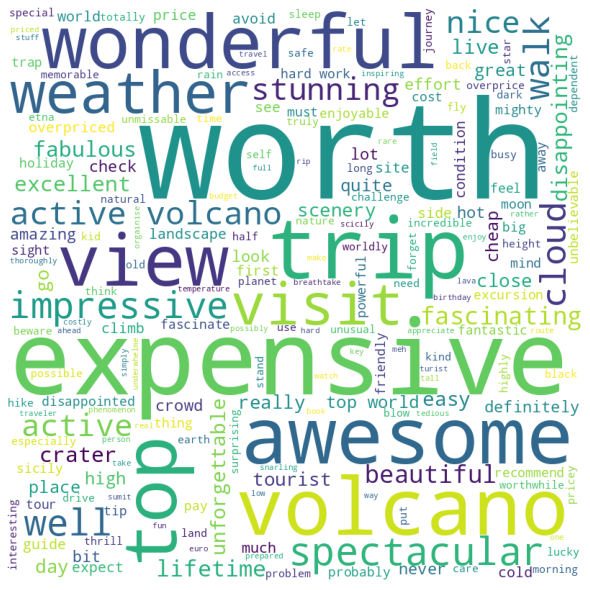

----------------------------------


Wordcloud for Title_Topic_1
0    581
1     51
Name: Title_sentiment_rating, dtype: int64


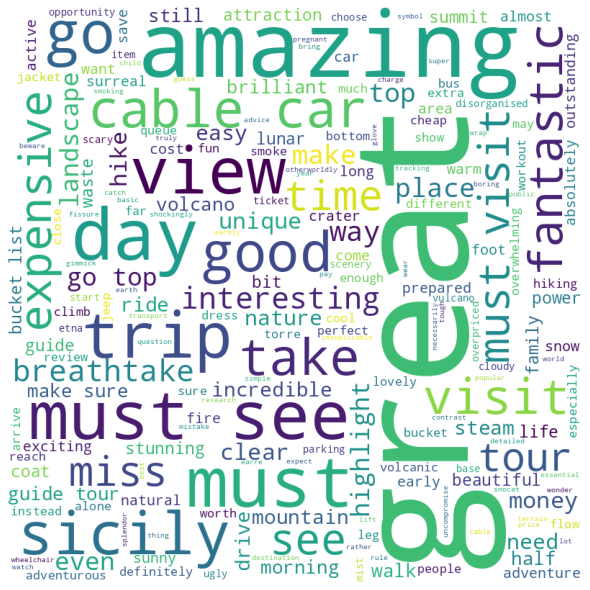

----------------------------------




In [26]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT POSITIVE

Wordcloud for Title_Topic_0
0    620
Name: Title_sentiment_rating, dtype: int64


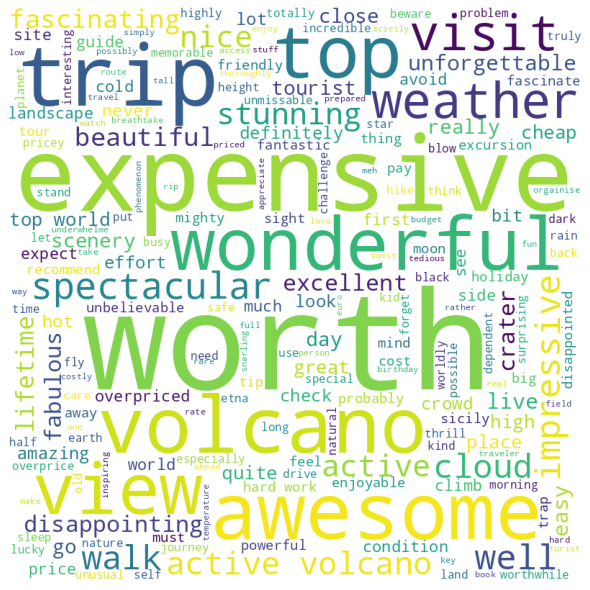

----------------------------------


Wordcloud for Title_Topic_1
0    581
Name: Title_sentiment_rating, dtype: int64


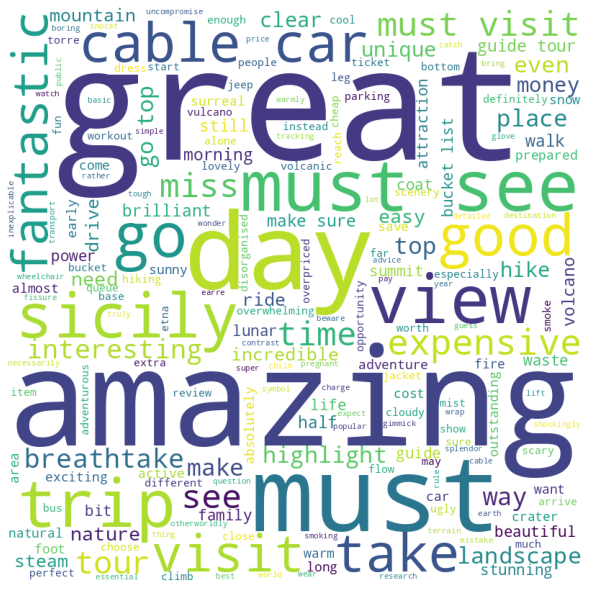

----------------------------------




In [27]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 0]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Titles - SENTIMENT NEGATIVE

Wordcloud for Title_Topic_0
1    100
Name: Title_sentiment_rating, dtype: int64


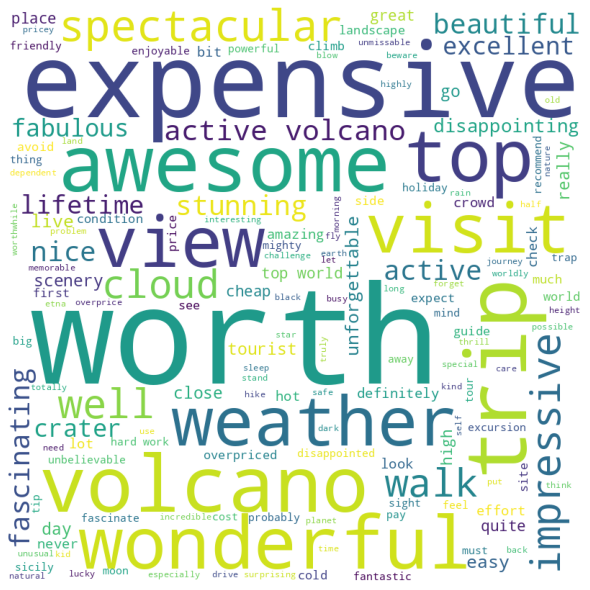

----------------------------------


Wordcloud for Title_Topic_1
1    51
Name: Title_sentiment_rating, dtype: int64


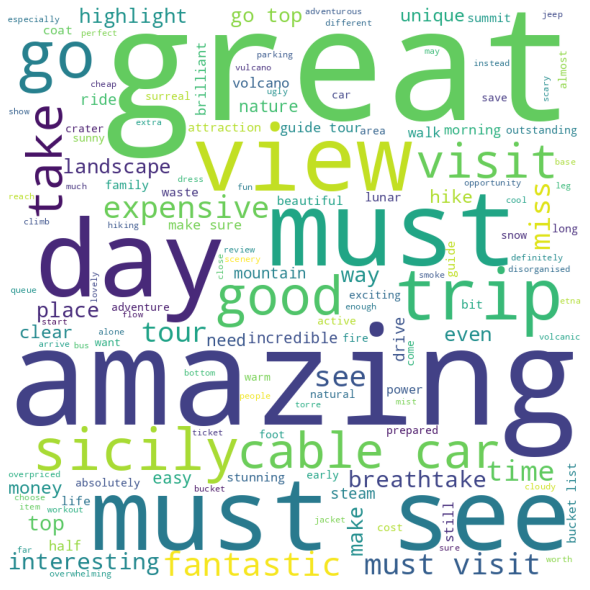

----------------------------------




In [28]:
for i in lda_title_data_tuned.filter(regex='Title_Topic_'):
    print('Wordcloud for {}'.format(i))
    title_topic = lda_title_data_tuned[lda_title_data_tuned['Title_sentiment_rating']== 1]
    title_topic = title_topic[title_topic['Title_Dominant_Topic']== i[len('Title_'):]]
    print(title_topic['Title_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_title_tuned, plot='wordcloud', topic_num=i[len('Title_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_title_tuned, plot='bigram', topic_num=i[len('Title_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_title_tuned, plot='trigram', topic_num=i[len('Title_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [29]:
# Evaluation of the model
evaluate_model(lda_title_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [30]:
lda_title_data_tuned

Title_title  Title_sentiment_rating  Title_Topic_0  \
0                         hard                       0       0.736887   
1           cost cable car top                       0       0.206992   
2        orgainise easy access                       0       0.865052   
3               cheap easy way                       0       0.578780   
4     question cable car child                       0       0.104014   
...                        ...                     ...            ...   
1347      fantastic kind thing                       0       0.619639   
1348                     dusty                       1       0.744124   
1349                                                 0       0.500000   
1350               fire sicily                       0       0.168461   
1351                  exciting                       0       0.251861   

      Title_Topic_1 Title_Dominant_Topic  Title_Perc_Dominant_Topic  
0          0.263113              Topic_0                       0.74  
1          0.793008              Topic_1                       0.79  
2          0.134948              Topic_0                       0.87  
3          0.421220              Topic_0                       0.58  
4          0.895986              Topic_1                       0.90  
...             ...                  ...                        ...  
1347       0.380361              Topic_0                       0.62  
1348       0.255876              Topic_0                       0.74  
1349       0.500000              Topic_0                       0.50  
1350       0.831539              Topic_1                       0.83  
1351       0.748139              Topic_1                       0.75  

[1352 rows x 6 columns]

In [31]:
lda_title_data_tuned.to_csv(base_dir + 'data/cable/lda_title_data_tuned.csv', index=False)

In [32]:
save_model(lda_title_tuned, base_dir + 'models/cable/model_title_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7fad8f5fe0a0>,
 '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/models/cable/model_title_jupyter.pkl')

# 4. NLP for review

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   author            1352 non-null   object
 1   title             1352 non-null   object
 2   content           1352 non-null   object
 3   rating            1352 non-null   int64 
 4   sentiment_rating  1352 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 52.9+ KB


In [34]:
noise_words_review = []
token_lists_review = [word_tokenize(each) for each in data['content']]
tokens_review = [item for sublist in token_lists_review for item in sublist]
print("Number of unique tokens then: ",len(set(tokens_review)))


Number of unique tokens then:  10733


In [35]:
one_percentile_review = int(len(set(tokens_review)) * 0.01)
top_1_percentile_review = Counter(tokens_review).most_common(one_percentile_review)
bottom_1_percentile_review = Counter(tokens_review).most_common()[-one_percentile_review:]

print(top_1_percentile_review[:10])
print('---------------')
print(bottom_1_percentile_review[:10])

[('the', 12542), ('.', 8901), (',', 7369), ('to', 6788), ('and', 6278), ('a', 5259), ('of', 3444), ('you', 3329), ('is', 2647), ('was', 2526)]
---------------
[('Warning', 1), ('Sunset', 1), ('sandy', 1), ('Saopienza', 1), ('truck/bus', 1), ('Obvious', 1), ('reflections', 1), (',Not', 1), ('worth.', 1), ('enjoysicily.eu', 1)]


In [36]:
noise_words_review.extend(eng_stop_words)
noise_words_review.extend([word for word, val in top_1_percentile_review])
noise_words_review.extend([word for word, val in bottom_1_percentile_review])

In [37]:
data

author                                        title  \
0          Teithiwr                   A hard climb, but worth it   
1            Anne N              Cost of cable car to the top???   
2     doorstomanual                 Well orgainised, easy access   
3          Emilie P             Cheap and easy way to do Mt Etna   
4        Jonathan L  Question about Etna Cable Cars and children   
...             ...                                          ...   
1347     Thibault J    Fantastic, if you like that kind of thing   
1348        Keith P                             A dusty old hill   
1349       DidgeAFC                                 Trip to Etna   
1350    Peter_Wello            Fire and ice at the top of Sicily   
1351          qio_s                           Exciting adventure   

                                                content  rating  \
0     August 2008. Arrived at Refugio Sapienza just ...       4   
1     How much does the cable car cost from Rifugio ...       4   
2     We visited Etna with two small children in Aug...       5   
3     We were able to experience Mt Etna without spe...       5   
4     We would like to visit Etna. We have a 3 year ...       5   
...                                                 ...     ...   
1347  The landscape is amazing and I would recommend...       5   
1348  Very expensive cable car ride - plus bus to su...       3   
1349  We drove to the base station where you take th...       4   
1350  Fantastic just to drive up the mountain throug...       5   
1351  I've been to Catania for 5 months with Erasmus...       5   

      sentiment_rating  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1347                 0  
1348                 1  
1349                 0  
1350                 0  
1351                 0  

[1352 rows x 5 columns]

In [38]:
# Pycaret
from pycaret.nlp import *

exp_name = setup(data = data[['content', 'sentiment_rating']],  
                 target = 'content',
                 session_id = 42,
                 custom_stopwords = noise_words_review
                )

In [39]:
lda_review = create_model('lda', multi_core = True) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review)
lda_review_data = assign_model(lda_review)

In [40]:
print('Shape of lda_review_data: ', lda_review_data.shape)
display(lda_review_data.head())
print('------')
lda_review_data.describe(include='all')

Shape of lda_review_data:  (1352, 8)


content  sentiment_rating  \
0  arrive make_sure allow plenty road long think ...                 0   
1  much cost charge really look receipt entry blo...                 0   
2  small child august use company sight however o...                 0   
3  able spend money research plenty euro leave re...                 0   
4    year_old month old know child young buggy thank                 0   

    Topic_0   Topic_1   Topic_2   Topic_3 Dominant_Topic  Perc_Dominant_Topic  
0  0.214191  0.459950  0.324770  0.001089        Topic 1                 0.46  
1  0.018625  0.019304  0.942604  0.019466        Topic 2                 0.94  
2  0.294318  0.693511  0.006064  0.006107        Topic 1                 0.69  
3  0.253580  0.708134  0.018976  0.019310        Topic 1                 0.71  
4  0.031908  0.029452  0.909724  0.028916        Topic 2                 0.91

------


content  sentiment_rating      Topic_0      Topic_1      Topic_2  \
count     1352       1352.000000  1352.000000  1352.000000  1352.000000   
unique    1351               NaN          NaN          NaN          NaN   
top                          NaN          NaN          NaN          NaN   
freq         2               NaN          NaN          NaN          NaN   
mean       NaN          0.111686     0.209790     0.416846     0.189503   
std        NaN          0.315097     0.313498     0.378333     0.306529   
min        NaN          0.000000     0.000752     0.000679     0.000459   
25%        NaN          0.000000     0.007860     0.017599     0.007657   
50%        NaN          0.000000     0.018999     0.364222     0.015809   
75%        NaN          0.000000     0.333138     0.792492     0.284793   
max        NaN          1.000000     0.990576     0.996518     0.996975   

            Topic_3 Dominant_Topic  Perc_Dominant_Topic  
count   1352.000000           1352          1352.000000  
unique          NaN              4                  NaN  
top             NaN        Topic 1                  NaN  
freq            NaN            588                  NaN  
mean       0.183861            NaN             0.783550  
std        0.292927            NaN             0.185074  
min        0.000459            NaN             0.250000  
25%        0.007703            NaN             0.620000  
50%        0.015994            NaN             0.830000  
75%        0.277914            NaN             0.960000  
max        0.993693            NaN             1.000000

## Tuning number of topics

In [41]:
tuned_lda_review = tune_model(model = 'lda', 
                             multi_core = True, 
                             supervised_target = 'sentiment_rating',
                             custom_grid = [2,3,4],
                             optimize = 'AUC'
                             )

IntProgress(value=0, description='Processing: ', max=13)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 2 | AUC : 0.6804


In [42]:
lda_review_tuned = create_model('lda', multi_core = True, num_topics=tuned_lda_review.num_topics) # Latent Dirichlet Allocation
print('Latent Dirichlet Allocation: ', lda_review_tuned)
lda_review_data_tuned = assign_model(lda_review_tuned)
lda_review_data_tuned = lda_review_data_tuned.add_prefix('Review_')
lda_review_data_tuned['Review_Dominant_Topic'] = lda_review_data_tuned['Review_Dominant_Topic'].replace(' ', '_', regex=True)

In [43]:
print('Shape of lda_review_data_tuned: ', lda_review_data_tuned.shape)
display(lda_review_data_tuned.head())
print('------')
lda_review_data_tuned.describe(include='all')

Shape of lda_review_data_tuned:  (1352, 6)


Review_content  Review_sentiment_rating  \
0  arrive make_sure allow plenty road long think ...                        0   
1  much cost charge really look receipt entry blo...                        0   
2  small child august use company sight however o...                        0   
3  able spend money research plenty euro leave re...                        0   
4    year_old month old know child young buggy thank                        0   

   Review_Topic_0  Review_Topic_1 Review_Dominant_Topic  \
0        0.051614        0.948386               Topic_1   
1        0.152423        0.847577               Topic_1   
2        0.120671        0.879329               Topic_1   
3        0.045210        0.954790               Topic_1   
4        0.693708        0.306292               Topic_0   

   Review_Perc_Dominant_Topic  
0                        0.95  
1                        0.85  
2                        0.88  
3                        0.95  
4                        0.69

------


Review_content  Review_sentiment_rating  Review_Topic_0  \
count            1352              1352.000000     1352.000000   
unique           1351                      NaN             NaN   
top                                        NaN             NaN   
freq                2                      NaN             NaN   
mean              NaN                 0.111686        0.395410   
std               NaN                 0.315097        0.353782   
min               NaN                 0.000000        0.002622   
25%               NaN                 0.000000        0.053295   
50%               NaN                 0.000000        0.284511   
75%               NaN                 0.000000        0.731266   
max               NaN                 1.000000        0.998322   

        Review_Topic_1 Review_Dominant_Topic  Review_Perc_Dominant_Topic  
count      1352.000000                  1352                 1352.000000  
unique             NaN                     2                         NaN  
top                NaN               Topic_1                         NaN  
freq               NaN                   840                         NaN  
mean          0.604590                   NaN                    0.837648  
std           0.353782                   NaN                    0.148510  
min           0.001678                   NaN                    0.500000  
25%           0.268734                   NaN                    0.720000  
50%           0.715489                   NaN                    0.900000  
75%           0.946705                   NaN                    0.960000  
max           0.997378                   NaN                    1.000000

In [44]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty road long think ...   
1     much cost charge really look receipt entry blo...   
2     small child august use company sight however o...   
3     able spend money research plenty euro leave re...   
4       year_old month old know child young buggy thank   
...                                                 ...   
1347  landscape amazing recommend whole place look m...   
1348  expensive ride summit try avoid crowd tourist ...   
1349  station nice visited relief give heat base sta...   
1350  fantastic change scenery become lunar approach...   
1351  active occasionally explode kilometer away str...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
0                           0        0.051614        0.948386   
1                           0        0.152423        0.847577   
2                           0        0.120671        0.879329   
3                           0        0.045210        0.954790   
4                           0        0.693708        0.306292   
...                       ...             ...             ...   
1347                        0        0.718355        0.281645   
1348                        1        0.067588        0.932412   
1349                        0        0.055850        0.944150   
1350                        0        0.987415        0.012585   
1351                        0        0.973628        0.026372   

     Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                  Topic_1                        0.95  
1                  Topic_1                        0.85  
2                  Topic_1                        0.88  
3                  Topic_1                        0.95  
4                  Topic_0                        0.69  
...                    ...                         ...  
1347               Topic_0                        0.72  
1348               Topic_1                        0.93  
1349               Topic_1                        0.94  
1350               Topic_0                        0.99  
1351               Topic_0                        0.97  

[1352 rows x 6 columns]

## Wordclouds, bigrams and trigrams for Reviews

Wordcloud for Review_Topic_0
0    466
1     46
Name: Review_sentiment_rating, dtype: int64


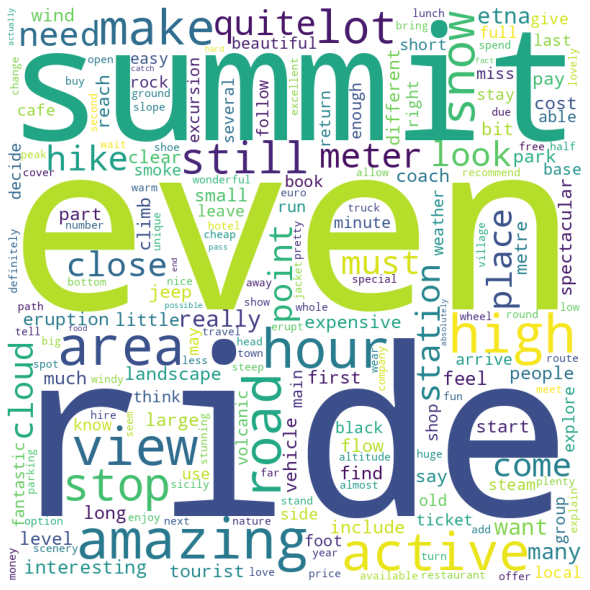

----------------------------------


Wordcloud for Review_Topic_1
0    735
1    105
Name: Review_sentiment_rating, dtype: int64


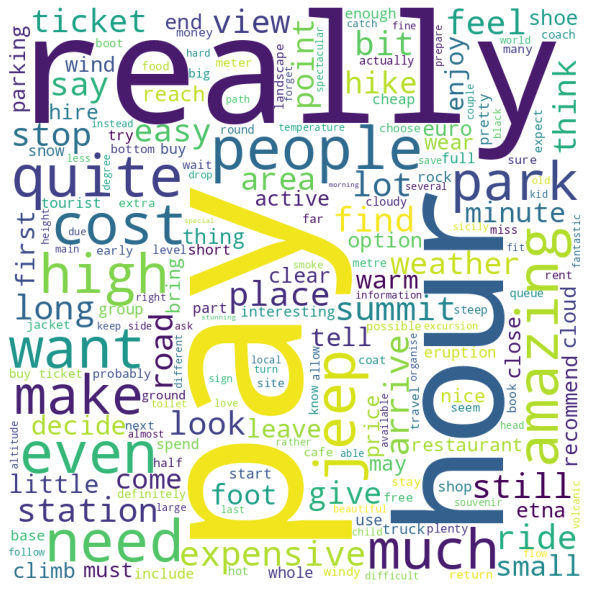

----------------------------------




In [45]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT POSITIVE

Wordcloud for Review_Topic_0
0    466
Name: Review_sentiment_rating, dtype: int64


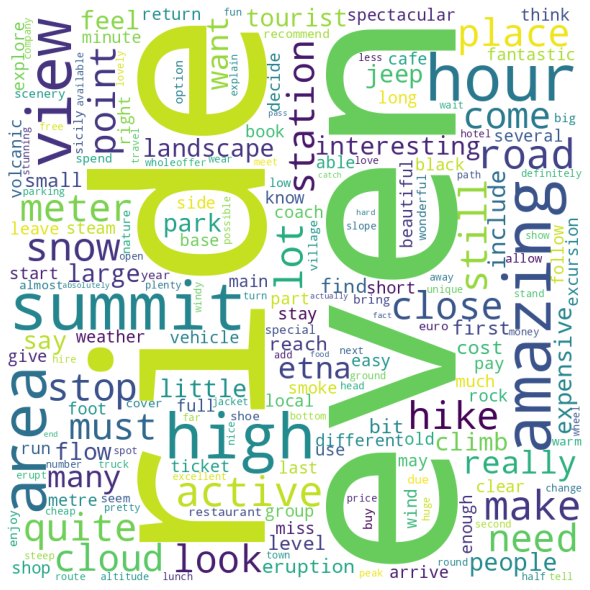

----------------------------------


Wordcloud for Review_Topic_1
0    735
Name: Review_sentiment_rating, dtype: int64


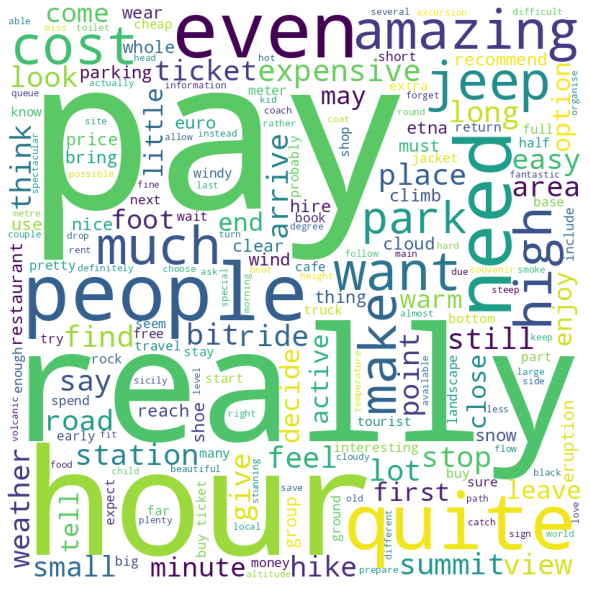

----------------------------------




In [46]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 0]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Wordclouds, bigrams and trigrams for Reviews - SENTIMENT NEGATIVE

Wordcloud for Review_Topic_0
1    46
Name: Review_sentiment_rating, dtype: int64


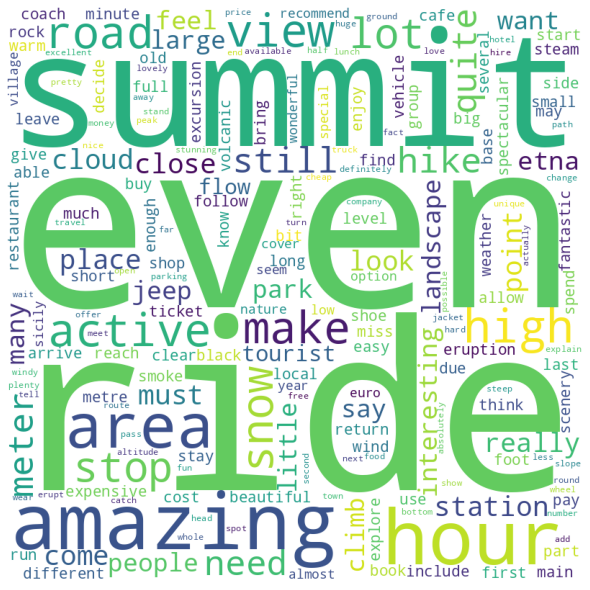

----------------------------------


Wordcloud for Review_Topic_1
1    105
Name: Review_sentiment_rating, dtype: int64


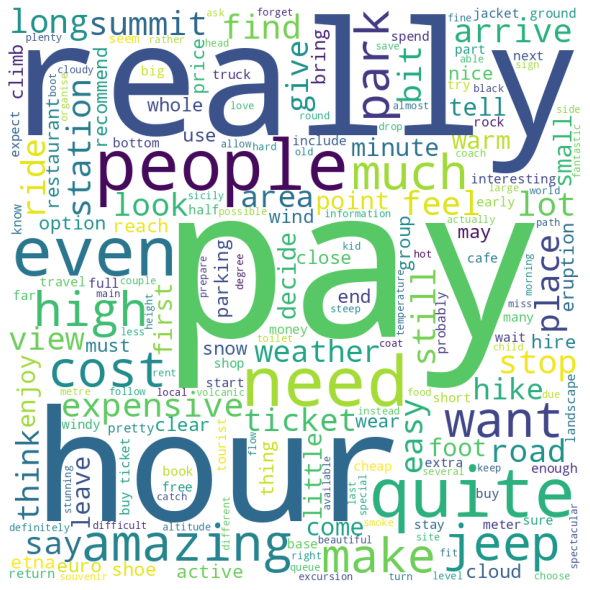

----------------------------------




In [47]:
for i in lda_review_data_tuned.filter(regex='Review_Topic_'):
    print('Wordcloud for {}'.format(i))
    review_topic = lda_review_data_tuned[lda_review_data_tuned['Review_sentiment_rating']== 1]
    review_topic = review_topic[review_topic['Review_Dominant_Topic']== i[len('Review_'):]]
    print(review_topic['Review_sentiment_rating'].value_counts())
    # WORDCLOUD
    plot_model(lda_review_tuned, plot='wordcloud', topic_num=i[len('Review_'):].replace('_', ' '), 
           #save=True
          )
    # BIGRAMS
    plot_model(lda_review_tuned, plot='bigram', topic_num=i[len('Review_'):].replace('_', ' '))
    # TRIGRAMS
    plot_model(lda_review_tuned, plot='trigram', topic_num=i[len('Review_'):].replace('_', ' '))
    
    print('----------------------------------')
    print('\n')

## Evaluation of the model

In [48]:
# Evaluation of the model
evaluate_model(lda_review_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

In [49]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty road long think ...   
1     much cost charge really look receipt entry blo...   
2     small child august use company sight however o...   
3     able spend money research plenty euro leave re...   
4       year_old month old know child young buggy thank   
...                                                 ...   
1347  landscape amazing recommend whole place look m...   
1348  expensive ride summit try avoid crowd tourist ...   
1349  station nice visited relief give heat base sta...   
1350  fantastic change scenery become lunar approach...   
1351  active occasionally explode kilometer away str...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
0                           0        0.051614        0.948386   
1                           0        0.152423        0.847577   
2                           0        0.120671        0.879329   
3                           0        0.045210        0.954790   
4                           0        0.693708        0.306292   
...                       ...             ...             ...   
1347                        0        0.718355        0.281645   
1348                        1        0.067588        0.932412   
1349                        0        0.055850        0.944150   
1350                        0        0.987415        0.012585   
1351                        0        0.973628        0.026372   

     Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                  Topic_1                        0.95  
1                  Topic_1                        0.85  
2                  Topic_1                        0.88  
3                  Topic_1                        0.95  
4                  Topic_0                        0.69  
...                    ...                         ...  
1347               Topic_0                        0.72  
1348               Topic_1                        0.93  
1349               Topic_1                        0.94  
1350               Topic_0                        0.99  
1351               Topic_0                        0.97  

[1352 rows x 6 columns]

In [50]:
lda_review_data_tuned.to_csv(base_dir + 'data/cable/lda_review_data_tuned.csv', index=False)

In [51]:
save_model(lda_review_tuned, base_dir + 'models/cable/model_review_jupyter')

Model Succesfully Saved


(<gensim.models.ldamulticore.LdaMulticore at 0x7fad8f0abe20>,
 '/mnt/g/My Drive/Academy/+ Papers/en_proceso/mount_etna/models/cable/model_review_jupyter.pkl')

In [52]:
lda_review_data_tuned

Review_content  \
0     arrive make_sure allow plenty road long think ...   
1     much cost charge really look receipt entry blo...   
2     small child august use company sight however o...   
3     able spend money research plenty euro leave re...   
4       year_old month old know child young buggy thank   
...                                                 ...   
1347  landscape amazing recommend whole place look m...   
1348  expensive ride summit try avoid crowd tourist ...   
1349  station nice visited relief give heat base sta...   
1350  fantastic change scenery become lunar approach...   
1351  active occasionally explode kilometer away str...   

      Review_sentiment_rating  Review_Topic_0  Review_Topic_1  \
0                           0        0.051614        0.948386   
1                           0        0.152423        0.847577   
2                           0        0.120671        0.879329   
3                           0        0.045210        0.954790   
4                           0        0.693708        0.306292   
...                       ...             ...             ...   
1347                        0        0.718355        0.281645   
1348                        1        0.067588        0.932412   
1349                        0        0.055850        0.944150   
1350                        0        0.987415        0.012585   
1351                        0        0.973628        0.026372   

     Review_Dominant_Topic  Review_Perc_Dominant_Topic  
0                  Topic_1                        0.95  
1                  Topic_1                        0.85  
2                  Topic_1                        0.88  
3                  Topic_1                        0.95  
4                  Topic_0                        0.69  
...                    ...                         ...  
1347               Topic_0                        0.72  
1348               Topic_1                        0.93  
1349               Topic_1                        0.94  
1350               Topic_0                        0.99  
1351               Topic_0                        0.97  

[1352 rows x 6 columns]